## Hecho Por: Juan Felipe Camelo, Silvana Sandoval, Adrián Suárez

### Importación de las librerías a usar

In [1]:
import pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Ejercicio 1

La solución propuesta se realiza con pyomo. Como variables teneoms los nodos del grafo, como parámetros tenemos la función de costos que conectan los nodos del grafo y el valor inicial del e-constraint; se puso el ejemplo del laboratorio. Posteriormente definimos un valor muy alto para asignar a las conexiones que no existen entre nodos, esto dado que neusta variable de decisión es binaria y requiere que existan las conexiones para poder correr el programa. 

Posteriormente creamos una lista donde guardaremos las tuplas (e-constraint, costo), que representan el valor de e-constraint, el cual indica la cantidad de saltos, y el costo total. El modelo busca minimizar la función de costo usando la función de saltos como una restricción, a la cuál se le aplica el e-constraint. Nuestra variable de decisión binaria nos indica aquellas conexiones que si vamos a tomar, y así minimizamos el costo. Las primeras 3 restricciones son las básicas para un grafo de flujo, estableciendo un nodo inicial, un nodo final, y que el flujo que sale es igual al que entra. Finalmente se agrega la función de "hops" como una restricción adicional, donde decimos que la cantidad de nodos recorridos entre el nodo de inicio y el final debe ser menor o igual al valor de e-constraint. 

Entrando en detalles técnicos, para iterar sobre los valores de e-constraint se usa un loop con while, y si al final se resuelve un modelo factible, se agrega la solución a la lista de resultados. Un modelo factible sería aquel cuyo costo sea igual al valor que inicialmente definimos como "muy alto" para conexiones inexistentes. En el ejemplo del enunciado, no existe forma de resolver el problema con 1 salto, pero en nuestro modelo si lo resolvería, con un costo de 10000, por lo cual se define que itere hasta que el valor del costo sea infactible. Para la impresión se invierte la tabla de resultados, puesto que el valor de e-constraint va disminuyendo, es decir, con 5 saltos máximos da el mismo resultado hasta 3, por lo cual el punto del óptimo de Pareto es 3 saltos, así que tomamos los valores al revés y aquellos que repitan costo solo los ignoramos. Finalmente se grafican los puntos que son óptimos de Pareto. 

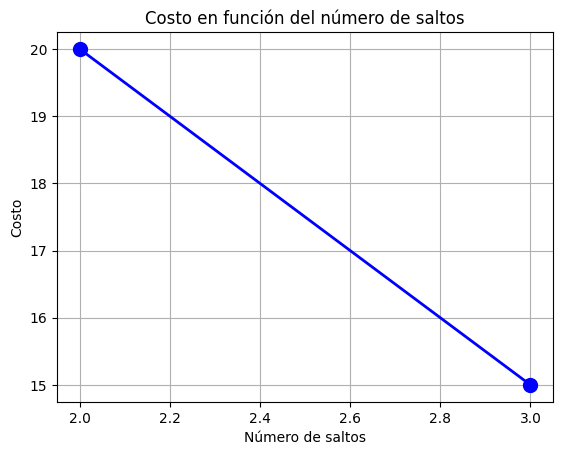

In [1]:

# Variables
nodos = ["n1", "n2", "n3", "n4", "n5"]


# Parámetros
costos = {"n1": {"n2": 10, "n3": 5},
          "n2": {"n5": 10},
          "n3": {"n4": 5},
          "n4": {"n5": 5}}
e_constraint = 5

# Asignar un costo muy alto a las conexiones inexistentes
costo_alto = 10000
for i in nodos:
    if i not in costos:
        costos[i] = {}
    for j in nodos:
        if j not in costos[i]:
            costos[i][j] = costo_alto

resultados = []
# Resolver para cada valor de e

while e_constraint > 0:

    # Crear el modelo
    model = ConcreteModel()

    # Variable de decisión
    model.x = Var(nodos, nodos, domain=Binary)

    # Función objetivo
    def objetivo(model):
        return sum(costos[i][j] * model.x[i, j] for i in nodos for j in nodos)
    model.objetivo = Objective(rule=objetivo, sense=minimize)

    ### Restricciones
    # Restricción para el nodo fuente
    def regla_fuente(model):
        return sum(model.x["n1", j] for j in nodos) == 1
    model.fuente = Constraint(rule=regla_fuente)

    # Restricción para el nodo destino
    def regla_destino(model):
        return sum(model.x[j, "n5"] for j in nodos) == 1
    model.destino = Constraint(rule=regla_destino)

    # Restricción para los nodos intermedios
    def regla_inter(model, i):
        if i not in ["n1", "n5"]:
            return sum(model.x[i, j] for j in nodos) - sum(model.x[j, i] for j in nodos) == 0
        else:
            return Constraint.Skip
    model.intermedio = Constraint(nodos, rule=regla_inter)

    # Restricción de salto
    def regla_hops(model):
        return sum(model.x[i, j] for i in nodos for j in nodos) <= e_constraint
    model.hops = Constraint(rule=regla_hops)

    #Resolver e
    solver = SolverFactory('glpk')
    solver.solve(model)
    #model.display()
    
    costo = value(model.objetivo)
    if costo < costo_alto:
        if (int, costo) not in resultados:
            resultados.append((e_constraint, costo))
            e_constraint -= 1
    else: break

# Recorrer los resultados al revés y eliminar duplicados
resultados_unicos = {}
for e_constraint, costo in reversed(resultados):
    if costo not in resultados_unicos:
        resultados_unicos[costo] = e_constraint

# Convertir el diccionario a una lista de tuplas y ordenar por e_constraint
resultados_filtrados = sorted(resultados_unicos.items(), key=lambda x: x[1])

# Mostrar resultados en una gráfica
x = [r[1] for r in resultados_filtrados]
y = [r[0] for r in resultados_filtrados]
plt.plot(x, y, 'b-', marker='o', markersize=10, linewidth=2)  # Puntos más grandes que la línea
plt.xlabel("Número de saltos")
plt.ylabel("Costo")
plt.title("Costo en función del número de saltos")
plt.grid(True)
plt.show()


# Ejercicio 2

Paso 1: Definir el problema teniendo en cuenta las variables de holgura. Esto se hace para convertir las desigualdades en igualdades. Para esto se transformará el problema: $$\text{max}(3x_1 + 2x_2)$$ en $$\text{max}(3x_1 + 2x_2+ 0s_1 + 0s_2 + 0s_3)$$ siendo $$s_1, s_2, s_3$$ las variables de holgura.

In [2]:
c = np.array([-3, -2, 0, 0, 0]) #Estás se añaden de manera negativa para poder añadirlas al simplex tableau después

Paso 2: Establecer la matriz de restricciones que se usará en las iteraciones. Esto se hace de esta manera, en una primera instancia, para entender con qué se está trabajando

In [3]:
tabla = {
    "Basic" : ['s1', 's2', 's3', 'Z'], #columna izquierda
    "x1": [2, 1, 1, -3],
    "x2": [1, 1, 0, -2],
    "s1": [1, 0, 0, 0],
    "s2": [0, 1, 0, 0],
    "s3": [0, 0, 1, 0],
    "b": [100, 80, 40, 0]
}

Paso 3: escribirla de tal manera que se pueda pasar por parámetro en una función sin problema alguno.

In [4]:
A = np.array([
    [2, 1, 1, 0, 0], 
    [1, 1, 0, 1, 0],
    [1, 0, 0, 0, 1]
], dtype=float)


Paso 4: escribir la columna b (la del lado derecho de la igualdad.)

In [5]:
b = np.array([100, 80, 40], dtype=float)

Paso 5: Construimos la tabla que tenga tanto la matriz A como el vector b. Además, le añadiremos una fila de costos para asegurarnos de poder identificar la columna pivote (es decir, la que reemplazará una de las variables slack).

In [6]:
tableau = np.hstack([A, b.reshape(-1, 1)]).astype(float) #Se convierte b en una matriz columna y se concatena con A
tableau = np.vstack([tableau, np.hstack([c, np.array([0])])]) #Se añade la matriz los costos hechos anteriormente

Paso 5: implementar el algoritmo simplex para resolver este problema.

In [7]:
def simplex(tableau, coordinates):

    num_rows, num_cols = tableau.shape

    x1, x2 = coordinates  # Coordenadas de las variables de decisión

    tableau[0, -1] = 100 - (2 * x1 + x2)  # Restricción 1: 2x1 + x2 <= 100
    tableau[1, -1] = 80 - (x1 + x2)       # Restricción 2: x1 + x2 <= 80
    tableau[2, -1] = 40 - x1              # Restricción 3: x1 <= 40

    # Iterar hasta que se cumpla la prueba de optimalidad (no haya negativos en la fila de Z)
    while np.any(tableau[-1, :-1] < 0):  # Si hay valores negativos, no es óptimo
        # 1. Identificar variable entrante: el valor más negativo en la fila de Z (función objetivo)
        pivot_col = np.argmin(tableau[-1, :-1])  # Columna con el valor más negativo
        
        # 2. Realizar la prueba de optimalidad: encontrar la variable saliente (la fila pivote)
        # Regla de la razón mínima: ratios de RHS / coeficientes de la columna pivote (sólo positivos)
        ratios = np.divide(tableau[:-1, -1], tableau[:-1, pivot_col],
                           out=np.full_like(tableau[:-1, -1], np.inf), 
                           where=tableau[:-1, pivot_col] > 0)
        pivot_row = np.argmin(ratios)  # Fila con el menor ratio positivo
        
        # 3. Realizar el pivoteo en torno al elemento pivote
        pivot_element = tableau[pivot_row, pivot_col]
        tableau[pivot_row, :] /= pivot_element  # Escalar la fila pivote para hacer el pivote = 1
        
        # Hacer ceros en las otras filas de la columna pivote
        for i in range(num_rows):
            if i != pivot_row:
                tableau[i, :] -= tableau[i, pivot_col] * tableau[pivot_row, :]
    
    # Cuando no haya valores negativos en la fila de Z, hemos alcanzado la optimalidad
    return tableau



Finalmente, nos encargaremos de calcular el tableua optimo e imprimirlo

In [8]:
coordenadas = np.array([0,0], dtype=float)
tableau_optimo = simplex(tableau=tableau, coordinates=coordenadas)
tableau_optimo = tableau_optimo.astype(int)
print("Optimal Tableau:\n", tableau_optimo)
print("Optimal Solution:", tableau_optimo[:, -1])

Optimal Tableau:
 [[  0   1  -1   2   0  60]
 [  0   0  -1   1   1  20]
 [  1   0   1  -1   0  20]
 [  0   0   1   1   0 180]]
Optimal Solution: [ 60  20  20 180]


Como se puede ver, los valores óptimos para $$x_1 = 40$$ y para $$x_2 = 100$$ 

Ahora para ver mejor el resultado se borrarán las filas que no son de las variables de holgura.

In [9]:
def contar_no_basicas(tabla):
    #primero, buscaremos el número de variables no báiscas dentro de la tabla de variables
    contador = 0
    for variable in tabla:
        if "x" in variable:
            contador +=1
    return contador

def eliminar_holgura(tabla, tableau):

    contador = contar_no_basicas(tabla)
    num_filas, num_columnas = tableau.shape

    #Ahora vamos a buscar las variables no basicas
    array = []
    for i in range (0, num_filas):
        element = tableau[i]

        for j in range (0, (contador)):
            x = element[j]
            if x == 1.:
                array.append(element.tolist())
    
    return array




In [10]:
array = eliminar_holgura(tabla=tabla, tableau=tableau)
for i in array:
    print(i)

[0.0, 1.0, -1.0, 2.0, 0.0, 60.0]
[1.0, 0.0, 1.0, -1.0, 0.0, 20.0]
